In [2]:
import geopandas as gpd
import pandas as pd

# Load NYC taxi zones shapefile
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")  # Contains LocationID and geometry

# Load aggregated hourly demand with PULocationID and DOLocationID
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate total rides by OD pair
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()

# Keep top 100 OD pairs for visualization
top_od = od_pairs.sort_values('rides', ascending=False).head(100)

In [3]:
zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [4]:
# Merge pickup zones
top_od = top_od.merge(zones[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones
top_od = top_od.merge(zones[['LocationID', 'geometry']], left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Compute centroids for line plotting
top_od['PU_centroid'] = top_od['PU_geometry'].centroid
top_od['DO_centroid'] = top_od['DO_geometry'].centroid

AttributeError: 'Series' object has no attribute 'centroid'

In [5]:
import geopandas as gpd
import pandas as pd
import folium

# Load taxi zones shapefile
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")

# Load aggregated OD demand
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate OD pairs
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(100)

# Merge pickup zones
top_od = top_od.merge(zones[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones
top_od = top_od.merge(zones[['LocationID', 'geometry']], left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Convert geometry columns to GeoSeries for centroid calculation
top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry']).centroid
top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry']).centroid

# --- 5. Create Interactive Map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add OD flow lines
for _, row in top_od.iterrows():
    pu_lat, pu_lon = row['PU_centroid'].y, row['PU_centroid'].x
    do_lat, do_lon = row['DO_centroid'].y, row['DO_centroid'].x
    folium.PolyLine(
        locations=[(pu_lat, pu_lon), (do_lat, do_lon)],
        color='blue',
        weight=min(row['rides'] / 500, 8),  # Scale thickness by demand
        opacity=0.6
    ).add_to(m)

# Save interactive map
m.save("od_flow_map.html")
print("Map saved as od_flow_map.html")

Map saved as od_flow_map.html


In [6]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.colors as mcolors

# --- 1. Load Taxi Zones Shapefile ---
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")  # Contains LocationID and geometry

# --- 2. Load Taxi Zone Lookup for Borough and Zone Names ---
lookup = pd.read_csv("data/taxi_zones/taxi_zone_lookup.csv")  # Columns: LocationID, Borough, Zone
zones = zones.merge(lookup, on="LocationID", how="left")

# --- 3. Load Aggregated OD Demand ---
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate OD pairs
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(20)  # Top 20 OD pairs

# --- 4. Project Zones for Accurate Centroid Calculation ---
zones_projected = zones.to_crs(epsg=2263)  # NYC State Plane CRS

# Merge pickup zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry', 'Zone': 'PUZone', 'Borough': 'PUBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry', 'Zone': 'DOZone', 'Borough': 'DOBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# --- 5. Compute Centroids in Projected CRS and Convert to WGS84 ---
top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid

# --- 6. Create Interactive Map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add Choropleth for Pickup Demand
pickup_demand = hourly.groupby('PULocationID')['rides'].sum().reset_index()
zones_wgs84 = zones.to_crs(epsg=4326)[['LocationID', 'geometry']]

folium.Choropleth(
    geo_data=zones_wgs84.__geo_interface__,  # Convert GeoDataFrame to GeoJSON
    data=pickup_demand,
    columns=['PULocationID', 'rides'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Pickup Demand'
).add_to(m)

# --- 7. Add OD Flow Lines with Color Gradient ---
# Normalize rides for color mapping
norm = mcolors.Normalize(vmin=top_od['rides'].min(), vmax=top_od['rides'].max())
cmap = mcolors.LinearSegmentedColormap.from_list("rides_gradient", ["blue", "red"])

for _, row in top_od.iterrows():
    pu_lat, pu_lon = row['PU_centroid'].y, row['PU_centroid'].x
    do_lat, do_lon = row['DO_centroid'].y, row['DO_centroid'].x

    # Color based on normalized rides
    color = mcolors.to_hex(cmap(norm(row['rides'])))

    # Dynamic weight (capped for visibility)
    weight = min(max(row['rides'] / 50, 3), 15)

    # Tooltip with zone names and boroughs
    tooltip_text = (f"PU: {row['PUZone']} ({row['PUBorough']}) → "
                    f"DO: {row['DOZone']} ({row['DOBorough']}) | Rides: {row['rides']}")

    folium.PolyLine(
        locations=[(pu_lat, pu_lon), (do_lat, do_lon)],
        color=color,
        weight=weight,
        opacity=0.8,
        tooltip=tooltip_text
    ).add_to(m)

# Save interactive map
m.save("od_flow_map.html")
print("✅ Map saved as od_flow_map.html")


/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/996573758.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/996573758.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid


✅ Map saved as od_flow_map.html


In [7]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.colors as mcolors

# --- 1. Load Taxi Zones Shapefile ---
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")  # Contains LocationID and geometry

# --- 2. Load Taxi Zone Lookup for Borough and Zone Names ---
lookup = pd.read_csv("data/taxi_zones/taxi_zone_lookup.csv")  # Columns: LocationID, Borough, Zone
zones = zones.merge(lookup, on="LocationID", how="left")

# --- 3. Load Aggregated OD Demand ---
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate OD pairs
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(20)  # Top 20 OD pairs

# --- 4. Project Zones for Accurate Centroid Calculation ---
zones_projected = zones.to_crs(epsg=2263)  # NYC State Plane CRS

# Merge pickup zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry', 'Zone': 'PUZone', 'Borough': 'PUBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry', 'Zone': 'DOZone', 'Borough': 'DOBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# --- 5. Compute Centroids in Projected CRS and Convert to WGS84 ---
top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid

# --- 6. Create Interactive Map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add Choropleth for Pickup Demand
pickup_demand = hourly.groupby('PULocationID')['rides'].sum().reset_index()
zones_wgs84 = zones.to_crs(epsg=4326)[['LocationID', 'geometry']]

folium.Choropleth(
    geo_data=zones_wgs84.__geo_interface__,  # Convert GeoDataFrame to GeoJSON
    data=pickup_demand,
    columns=['PULocationID', 'rides'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Pickup Demand'
).add_to(m)

# --- 7. Add OD Flow Lines with Color Gradient ---
# Normalize rides for color mapping
norm = mcolors.Normalize(vmin=top_od['rides'].min(), vmax=top_od['rides'].max())
cmap = mcolors.LinearSegmentedColormap.from_list("rides_gradient", ["blue", "red"])

for _, row in top_od.iterrows():
    pu_lat, pu_lon = row['PU_centroid'].y, row['PU_centroid'].x
    do_lat, do_lon = row['DO_centroid'].y, row['DO_centroid'].x

    # Color based on normalized rides
    color = mcolors.to_hex(cmap(norm(row['rides'])))

    # Dynamic weight (capped for visibility)
    weight = min(max(row['rides'] / 50, 3), 15)

    # Tooltip text
    tooltip_text = (f"PU: {row['PUZone']} ({row['PUBorough']}) → "
                    f"DO: {row['DOZone']} ({row['DOBorough']}) | Rides: {row['rides']}")

    # Popup with mini bar chart (HTML)
    popup_html = f"""
    <div style="font-size:14px;">
        <b>OD Pair:</b><br>
        {row['PUZone']} → {row['DOZone']}<br>
        <b>Boroughs:</b> {row['PUBorough']} → {row['DOBorough']}<br>
        <b>Rides:</b> {row['rides']}<br>
        <div style="background:#ddd; width:200px; height:20px;">
            <div style="background:{color}; width:{min(row['rides']/norm.vmax*200,200)}px; height:20px;"></div>
        </div>
    </div>
    """

    folium.PolyLine(
        locations=[(pu_lat, pu_lon), (do_lat, do_lon)],
        color=color,
        weight=weight,
        opacity=0.8,
        tooltip=tooltip_text,
        popup=folium.Popup(popup_html, max_width=250)
    ).add_to(m)

# --- 8. Add Legend for Color Gradient ---
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 60px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px; padding:10px;">
<b>OD Flow Intensity</b><br>
<span style="color:blue;">&#9632;</span> Low &nbsp;&nbsp;
<span style="color:red;">&#9632;</span> High
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save interactive map
m.save("od_flow_map.html")
print("✅ Map saved as od_flow_map.html")

/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/1518747245.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/1518747245.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid


✅ Map saved as od_flow_map.html


In [8]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.colors as mcolors

# --- 1. Load Taxi Zones Shapefile ---
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")  # Contains LocationID and geometry

# --- 2. Load Taxi Zone Lookup for Borough and Zone Names ---
lookup = pd.read_csv("data/taxi_zones/taxi_zone_lookup.csv")  # Columns: LocationID, Borough, Zone
zones = zones.merge(lookup, on="LocationID", how="left")

# --- 3. Load Aggregated OD Demand ---
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate OD pairs
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(20)  # Top 20 OD pairs

# --- 4. Project Zones for Accurate Centroid Calculation ---
zones_projected = zones.to_crs(epsg=2263)  # NYC State Plane CRS

# Merge pickup zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry', 'Zone': 'PUZone', 'Borough': 'PUBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry', 'Zone': 'DOZone', 'Borough': 'DOBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# --- 5. Compute Centroids in Projected CRS and Convert to WGS84 ---
top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid

# --- 6. Create Interactive Map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add Choropleth for Pickup Demand
pickup_demand = hourly.groupby('PULocationID')['rides'].sum().reset_index()
zones_wgs84 = zones.to_crs(epsg=4326)[['LocationID', 'geometry']]

folium.Choropleth(
    geo_data=zones_wgs84.__geo_interface__,  # Convert GeoDataFrame to GeoJSON
    data=pickup_demand,
    columns=['PULocationID', 'rides'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Pickup Demand'
).add_to(m)

# --- 7. Add OD Flow Lines with Color Gradient ---
# Normalize rides for color mapping
norm = mcolors.Normalize(vmin=top_od['rides'].min(), vmax=top_od['rides'].max())
cmap = mcolors.LinearSegmentedColormap.from_list("rides_gradient", ["blue", "red"])

for _, row in top_od.iterrows():
    pu_lat, pu_lon = row['PU_centroid'].y, row['PU_centroid'].x
    do_lat, do_lon = row['DO_centroid'].y, row['DO_centroid'].x

    # Color based on normalized rides
    color = mcolors.to_hex(cmap(norm(row['rides'])))

    # Dynamic weight (capped for visibility)
    weight = min(max(row['rides'] / 50, 3), 15)

    # Tooltip text (cleaner format)
    tooltip_text = (
        f"<b>PU:</b> {row['PUZone']} ({row['PUBorough']})<br>"
        f"<b>DO:</b> {row['DOZone']} ({row['DOBorough']})<br>"
        f"<b>Rides:</b> {row['rides']}"
    )

    # Popup with larger font and bar chart
    popup_html = f"""
    <div style="font-size:18px; line-height:1.4;">
        <b>OD Pair:</b><br>
        {row['PUZone']} → {row['DOZone']}<br>
        <b>Boroughs:</b> {row['PUBorough']} → {row['DOBorough']}<br>
        <b>Rides:</b> {row['rides']}<br>
        <div style="background:#ddd; width:220px; height:24px; margin-top:5px;">
            <div style="background:{color}; width:{min(row['rides']/norm.vmax*220,220)}px; height:24px;"></div>
        </div>
    </div>
    """

    folium.PolyLine(
        locations=[(pu_lat, pu_lon), (do_lat, do_lon)],
        color=color,
        weight=weight,
        opacity=0.8,
        tooltip=tooltip_text,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# --- 8. Add Bigger Legend ---
legend_html = """
<div style="
    position: fixed; bottom: 50px; left: 50px; width: 220px; height: 90px;
    background-color: white; border: 2px solid grey; z-index: 9999;
    font-size: 18px; font-weight: bold; padding: 15px;">
<b>OD Flow Intensity</b><br>
<span style="color:blue; font-size:22px;">&#9632;</span> Low &nbsp;&nbsp;
<span style="color:red; font-size:22px;">&#9632;</span> High
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save interactive map
m.save("od_flow_map.html")
print("✅ Map saved as od_flow_map.html")


/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/1851848239.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/1851848239.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid


✅ Map saved as od_flow_map.html


In [9]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.colors as mcolors
from branca.colormap import LinearColormap

# --- 1. Load Taxi Zones Shapefile ---
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")  # Contains LocationID and geometry

# --- 2. Load Taxi Zone Lookup for Borough and Zone Names ---
lookup = pd.read_csv("data/taxi_zones/taxi_zone_lookup.csv")  # Columns: LocationID, Borough, Zone
zones = zones.merge(lookup, on="LocationID", how="left")

# --- 3. Load Aggregated OD Demand ---
hourly = pd.read_parquet("data/daily_demand_partitioned/final")

# Aggregate OD pairs
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(20)  # Top 20 OD pairs

# --- 4. Project Zones for Accurate Centroid Calculation ---
zones_projected = zones.to_crs(epsg=2263)  # NYC State Plane CRS

# Merge pickup zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'PU_geometry', 'Zone': 'PUZone', 'Borough': 'PUBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# Merge drop-off zones with names
top_od = top_od.merge(zones_projected[['LocationID', 'geometry', 'Zone', 'Borough']],
                      left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'geometry': 'DO_geometry', 'Zone': 'DOZone', 'Borough': 'DOBorough'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# --- 5. Compute Centroids in Projected CRS and Convert to WGS84 ---
top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid

# --- 6. Create Interactive Map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add Choropleth for Pickup Demand
pickup_demand = hourly.groupby('PULocationID')['rides'].sum().reset_index()
zones_wgs84 = zones.to_crs(epsg=4326)[['LocationID', 'geometry']]

folium.Choropleth(
    geo_data=zones_wgs84.__geo_interface__,  # Convert GeoDataFrame to GeoJSON
    data=pickup_demand,
    columns=['PULocationID', 'rides'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Pickup Demand'
).add_to(m)

# --- 7. Add OD Flow Lines with Color Gradient ---
# Normalize rides for color mapping
min_rides, max_rides = top_od['rides'].min(), top_od['rides'].max()
colormap = LinearColormap(colors=['blue', 'red'], vmin=min_rides, vmax=max_rides)
colormap.caption = 'OD Flow Intensity (Rides)'

for _, row in top_od.iterrows():
    pu_lat, pu_lon = row['PU_centroid'].y, row['PU_centroid'].x
    do_lat, do_lon = row['DO_centroid'].y, row['DO_centroid'].x

    # Color based on normalized rides
    color = colormap(row['rides'])

    # Dynamic weight (capped for visibility)
    weight = min(max(row['rides'] / 50, 3), 15)

    # Tooltip text
    tooltip_text = (f"PU: {row['PUZone']} ({row['PUBorough']}) → "
                    f"DO: {row['DOZone']} ({row['DOBorough']}) | Rides: {row['rides']}")

    # Popup with mini bar chart (HTML)
    popup_html = f"""
    <div style="font-size:14px;">
        <b>OD Pair:</b><br>
        {row['PUZone']} → {row['DOZone']}<br>
        <b>Boroughs:</b> {row['PUBorough']} → {row['DOBorough']}<br>
        <b>Rides:</b> {row['rides']}<br>
        <div style="background:#ddd; width:200px; height:20px;">
            <div style="background:{color}; width:{min(row['rides']/max_rides*200,200)}px; height:20px;"></div>
        </div>
    </div>
    """

    folium.PolyLine(
        locations=[(pu_lat, pu_lon), (do_lat, do_lon)],
        color=color,
        weight=weight,
        opacity=0.8,
        tooltip=tooltip_text,
        popup=folium.Popup(popup_html, max_width=250)
    ).add_to(m)

# --- 8. Add Dynamic Color Scale Legend ---
colormap.add_to(m)

# Save interactive map
m.save("od_flow_map.html")
print("✅ Map saved as od_flow_map.html")

/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/503799921.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['PU_centroid'] = gpd.GeoSeries(top_od['PU_geometry'], crs=2263).to_crs(epsg=4326).centroid
/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_90645/503799921.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_od['DO_centroid'] = gpd.GeoSeries(top_od['DO_geometry'], crs=2263).to_crs(epsg=4326).centroid


✅ Map saved as od_flow_map.html


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

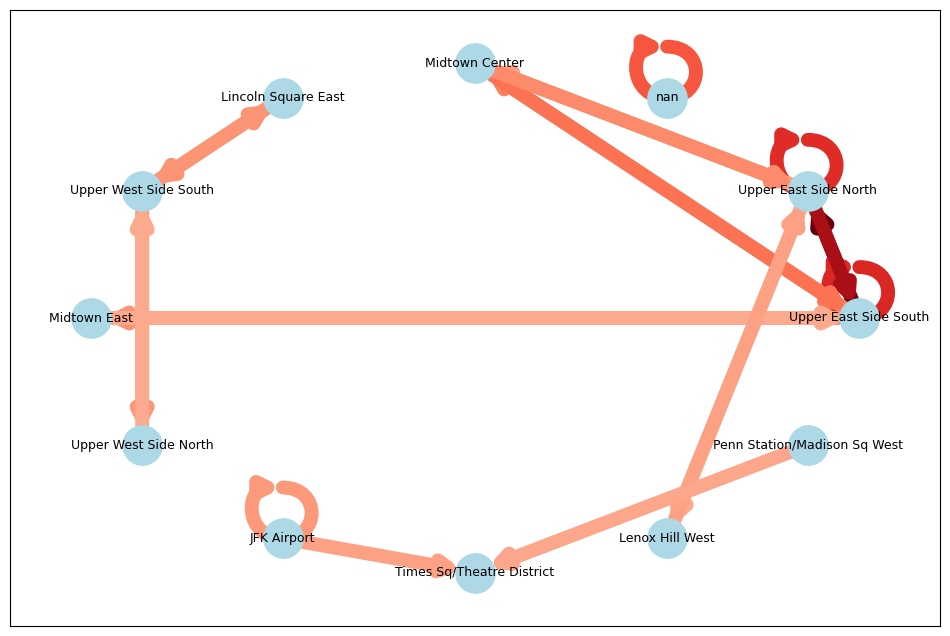

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# --- Load Data (same as before) ---
zones = gpd.read_file("data/taxi_zones/taxi_zones.shp")
lookup = pd.read_csv("data/taxi_zones/taxi_zone_lookup.csv")
zones = zones.merge(lookup, on="LocationID", how="left")

hourly = pd.read_parquet("data/daily_demand_partitioned/final")
od_pairs = hourly.groupby(['PULocationID', 'DOLocationID'])['rides'].sum().reset_index()
top_od = od_pairs.sort_values('rides', ascending=False).head(20)

# Merge zone names for labels
top_od = top_od.merge(lookup[['LocationID', 'Zone']], left_on='PULocationID', right_on='LocationID')
top_od.rename(columns={'Zone': 'PUZone'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

top_od = top_od.merge(lookup[['LocationID', 'Zone']], left_on='DOLocationID', right_on='LocationID')
top_od.rename(columns={'Zone': 'DOZone'}, inplace=True)
top_od.drop(columns=['LocationID'], inplace=True)

# --- Create Directed Graph ---
G = nx.DiGraph()

for _, row in top_od.iterrows():
    G.add_edge(row['PUZone'], row['DOZone'], weight=row['rides'])

# Node positions (circular layout for clarity)
pos = nx.circular_layout(G)

# Edge weights and colors
weights = [min(d['weight'] / 500, 10) for _, _, d in G.edges(data=True)]
colors = [plt.cm.Reds(d['weight'] / max(top_od['rides'])) for _, _, d in G.edges(data=True)]

# --- Plot ---
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, width=weights, edge_color=colors, arrows=True, arrowsize=20)

# Add title and colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(top_od['rides']), vmax=max(top_od['rides'])))
sm.set_array([])
plt.colorbar(sm, label='Ride Volume')

plt.title("Top 20 Taxi OD Flows (Static Graph)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("od_flow_static.png", dpi=300)
plt.show()